In [3]:
import pandas as pd                                   # для работы с датафреймом
import numpy as np                                    # для вычислений
import seaborn as sns                                 # для графиков
import matplotlib.pyplot as plt                       # для графиков
from scipy.stats import norm                          # проверка распределения
from scipy import stats                               # статистический анализ
import scipy.stats as stats                           # статистический анализ
from mlxtend.evaluate import permutation_test         # перестановочный тест
import statsmodels.stats.multicomp as mc              # HDS тест для определения групп
import re                                             # для регулярных выражений
from nltk.tokenize import RegexpTokenizer             # библиотека для работы с естественным языком
import nltk                                           # для обработки естественного языка
from nltk import word_tokenize                        # для деления предложений на слова
from nltk.corpus import stopwords                     # для исключения стоп-слов
from wordcloud import WordCloud, STOPWORDS            # для облака слов
from textblob import TextBlob                         # для анализа эмоций


In [4]:
#! pip install mlxtend

In [5]:
#! pip install wordcloud

In [6]:
#! pip install textblob

In [7]:
#! pip install pingouin

In [8]:
import pingouin as pg               # базовые функции библиотеки
from pingouin import welch_anova    # тест Велча

# Загрузка данных и общий обзор #

In [9]:
db = pd.read_csv ('data/books_tidy_data.csv', parse_dates = ['publication_date'], dtype = { 'decade' : 'object', 'quarter' : 'object' , 'tra_co' : 'object' })
# загружаем данные и исправляем тип данных

In [10]:
db.head()

,publication_date,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publisher,decade,quarter,tra_co
0,2006-09-16,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling,Mary GrandPré",4.57,eng,652,2095690,27591,Scholastic Inc.,2000,3,1
1,2004-09-01,Harry Potter and the Order of the Phoenix (Har...,"J.K. Rowling,Mary GrandPré",4.49,eng,870,2153167,29221,Scholastic Inc.,2000,3,1
2,2003-11-01,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,Scholastic,2000,4,0
3,2004-05-01,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling,Mary GrandPré",4.56,eng,435,2339585,36325,Scholastic Inc.,2000,2,1
4,2004-09-13,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"J.K. Rowling,Mary GrandPré",4.78,eng,2690,41428,164,Scholastic,2000,3,1


In [11]:
db = db.set_index ('publication_date') # установка даты в качестве индекса

In [12]:
db.info() # общий обзор данных

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10838 entries, 2006-09-16 to 2006-05-28
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               10838 non-null  object 
 1   authors             10838 non-null  object 
 2   average_rating      10838 non-null  float64
 3   language_code       10838 non-null  object 
 4   num_pages           10838 non-null  int64  
 5   ratings_count       10838 non-null  int64  
 6   text_reviews_count  10838 non-null  int64  
 7   publisher           10838 non-null  object 
 8   decade              10838 non-null  object 
 9   quarter             10838 non-null  object 
 10  tra_co              10838 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 1016.1+ KB


# Цели исследования 
1. характеристики центрального положения для количественных признаков (метод describe)
2. характеристики категориальных данных (метод describe)
3. распределение книг по десятилетиям (график)
4. распределение книг по кварталам (график)
5. книги и авторы с высокими оценками
6. наиболее часто издаваемые книги, авторы (график)
7. влияние соавторов и переводчиков на оценку (дисперсионный анализ)
8. признаки, влияющие на оценку книги (корреляция, дисперсионный анализ)
9. наиболее часто используемые слова в названии книги (NLTK)


# Характеристики центрального положения

In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # убираем в выводе экспоненту

In [14]:
db.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,10838.000,10838.000,10838.000,10838.000
mean,3.942,344.175,18347.883,553.075
std,0.295,238.556,113866.010,2599.330
min,1.000,11.000,0.000,0.000
25%,3.770,203.000,117.000,10.000
50%,3.960,304.000,803.500,49.000
75%,4.130,417.000,5226.750,248.000
max,5.000,6576.000,4597666.000,94265.000


In [15]:
av = np.array(db['average_rating'])
stats.trim_mean(av, 0.1) # робастная оценка среднего

3.9531780442804427

In [16]:
db['average_rating'].mad() # медианное абсолютное отклонение

0.224434581719725

Для лучшего понимания признаков следует их описать.
### average_rating
средняя оценка книги, всего значений 10 838, что совпадает для всех признаков, средняя оценка 3.942, стандартное отклонение 0.295.  
Мы дополнительно вычислили робастную оценку среднего 3.953 и медиану для отклонений от среднего 0.224.  
Можно сделать общий вывод, что читатели ставят оценку 3 или 4. Только 25% оценок ниже 3.77
### num_pages
количество страниц в книге, среднее значение 344 страницы. При этом максимальное достигает 6 576 страниц.  
Очевидно, что это выброс (и не один), который нужно будет учитывать при тестировании
### ratings_count
количество оценок, на одну книгу приходится 18 347 отзывов, стандартное отклонение 113 866 (очень много! значит есть книги с аномально большим количеством оценок).  
Но есть книги и с 0 оценок. При этом нижние 25% значений количества оценок меньше 117. Максимальное значение составляет 4 597 666 (почти 5 млн, что это за книга!?)
### text_reviews_count
количество отзывов, в среднем одна книга получает 553 отзыва при среднем отклонении 2 599. Есть книги, у которых отзывы отсутствуют.  
При этом нижние 25% значений количества отзывов составляет 10 отзывов, максимальное значение составляет 94 265.  
Совпадает ли это с максимальным количеством оценок?

In [17]:
db[db['ratings_count'] == 4597666]

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publisher,decade,quarter,tra_co
publication_date,,,,,,,,,,,
2006-09-06,Twilight (Twilight #1),Stephenie Meyer,3.590,eng,501,4597666,94265,Little Brown and Company,2000,3,0


Данная книга имеет максимальное количество оценок и максимальное количсетво отзывов 

# Характеристики категориальных данных

In [18]:
db[['title', 'authors', 'language_code', 'publisher', 'decade', 'quarter', 'tra_co']].describe() # опишем категориальные признаки

,title,authors,language_code,publisher,decade,quarter,tra_co
count,10838,10838,10838,10838,10838,10838,10838
unique,10149,6456,26,2226,13,4,2
top,The Odyssey,P.G. Wodehouse,eng,Vintage,2000,3,0
freq,8,40,8669,318,7332,2851,6492


10 149 уникальных значений названий из 10 838. Чаще всего встречается The Iliad, 8 раз (если таких книг несколько, то рандомно отображается одна из них).  
Уникальных значений авторов 6 456, наиболее часто встречающееся P.G. Wodehouse (40 раз). 26 различных значений языков, наиболее часто встречающееся eng (8 669 раз).  
Уникальных значений издателей 2 226, наиболее часто встречающееся Vintage (318 раз). Всего значений декад 13, наиболее часто встречающееся 2 000 (7 332 раза).  
Всего значений кварталов 4, наиболее часто встречающееся 3 (2 851 раз). Категорий "с соавтором / переводчиком" всего две (есть / нет). Чаще всего нет, таких случаев 6 492.


# Визуализация данных  
Визуализация используется для того, чтобы "схватить" какие-то гипотезы на имеющихся данных (визуально человеку проще это сделать).  
Однако размещение слишком большого количества данных на графике уменьшает этот эффект простоты. Например, на одном графике можно точками  
отразить распределение по двум признакам, добавить третий признак цветом точек, четвертый - размером точек, пятый - их формой.  
Но такой график будет сложен для чтения, а значит и смысл в визуализации теряется.  

В данном случае мы хотим установить следующее:  
1. распределение целевого признака - средняя оценка  
2. наличие выбросов по количественным признакам  
3. наличие взаимосвязи между признаками  
4. соотношение категориальных данных там, где это уместно 


Text(0.5, 1.0, 'Распределение средних оценок')

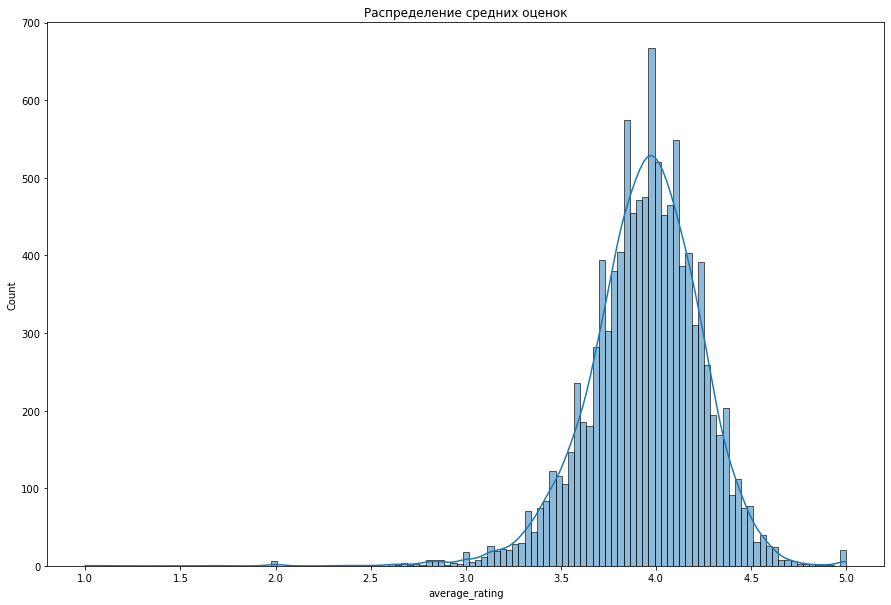

In [19]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(db['average_rating'], kde = 'True') # линия это плотность распределения, kde ядерная оценка плотности
plt.title('Распределение средних оценок')

Из графика видно, что средние оценки распределены практически нормально. Но в интервалах (2.5 ; 3.0) и (4.8 ; 5.0) имеются небольшие подъемы линии.  
При нормальном распределении этого не должно быть. Это означает, что оценки в указанных интервалах мы наблюдаем чаще, чем это предсказывает нормальное распределение.  
Дополнительная проверка на нормальность распределения с помощью статистических методов будет показана ниже.

#### Анализ выбросов
с помощью boxplots из библиотеки seaborn

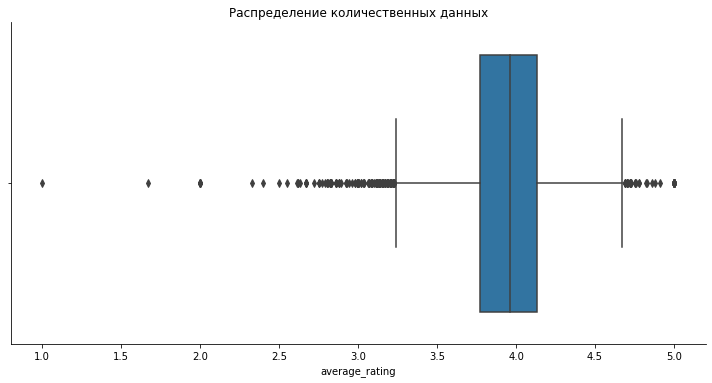

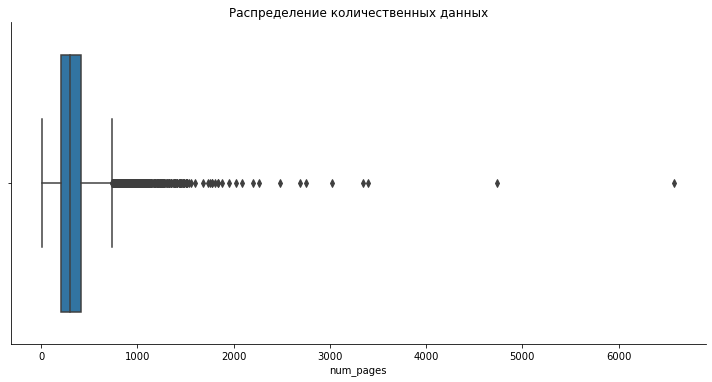

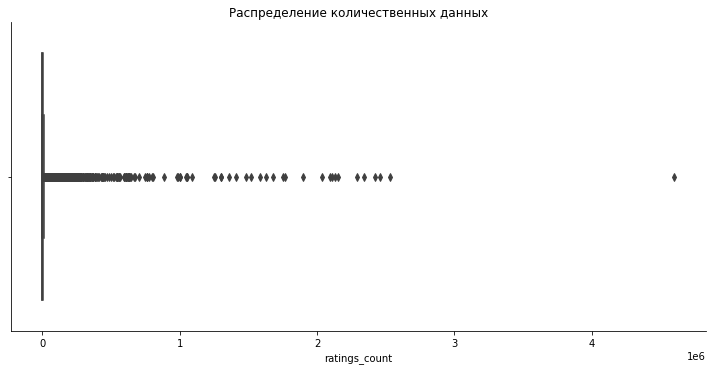

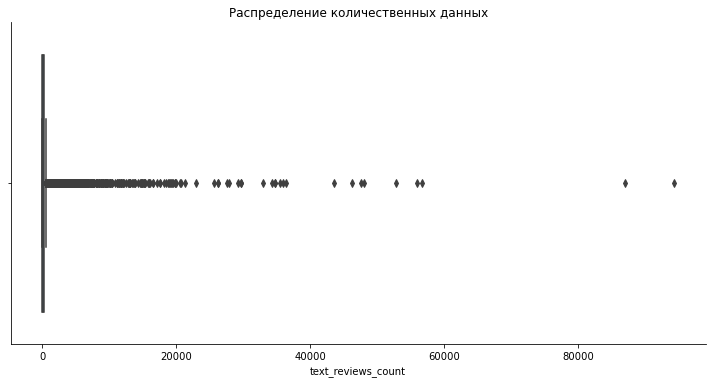

In [21]:
for i in ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']:
    sns.catplot(kind = 'box', data = db, aspect = 2, x = i)
    plt.title('Распределение количественных данных')